In [1]:
#import Pkg
using Yao
using Yao.ConstGate 
using Plots
using BenchmarkTools
using Printf
using StatsBase

In [2]:
#=
H(t) = Ω(t) ∑_i σ_i^x - δ(t) ∑_i n_i + u ∑_ij n_i n_j
=#

const u = 1.35
const Ω_max = 1.89
const δ_0 = -1.0
const δ_max = 1.0

function get_edges(graph::Vector{NTuple{2, Float64}})
    Nv = size(graph)[1]
    edges = falses(Nv, Nv)
    for i in 1:(Nv-1)
        xi, yi = graph[i]
        for j in (i+1):Nv
            xj, yj = graph[j]

            dij = sqrt((xi - xj)^2. + (yi - yj)^2.)
            if dij <= 1.0
                edges[i,j] = true
            end
        end
    end
    return findall(edges)
end

function Ω(t::Float64)
    if 0 <= t <= 0.25
        return (Ω_max / 0.25) * t
    elseif 0.25 < t <= 0.69
        return Ω_max
    elseif 0.69 < t <= 1
        return - Ω_max * t / 0.31 + Ω_max * (1 + 0.69/0.31)
    end
end

function δ(t::Float64)
    slope = (δ_0 - δ_max)/(0.25 - 0.69)
    if 0 <= t <= 0.25
        return δ_0
    elseif 0.25 < t <= 0.69
        return t * slope + (δ_max - slope * 0.69)
    elseif 0.69 < t <= 1
        return δ_max
    end
end 

function hamiltonian(graph::Vector{NTuple{2, Float64}}, edges::Vector{CartesianIndex{2}}, t::Float64)
    # the UD-MIS Hamiltonian
    Nv = size(graph)[1] # number of vertices

    interaction_term = map(1:size(edges)[1]) do i
        l,m = edges[i][1], edges[i][2]
        repeat(Nv,u*P1,(l,m))
    end |> sum
    interaction_term - δ(t)*sum(map(i->put(Nv,i=>P1), 1:Nv)) + Ω(t)*sum(map(i->put(Nv,i=>X), 1:Nv))
end

function run_annealing(graph::Vector{NTuple{2, Float64}}, edges::Vector{CartesianIndex{2}}, dt::Float64)
    psi_t = zero_state(size(graph)[1])
    for t in 0:dt:1.0
        h = hamiltonian(graph, edges, t)
        psi_t = psi_t |> TimeEvolution(h, dt * 100)
    end
    return psi_t
end

run_annealing (generic function with 1 method)

In [39]:
graph = [(0.3461717838632017, 1.4984640297338632), 
         (0.6316400411846113, 2.5754677320579895), 
         (1.3906262250927481, 2.164978861396621), 
         (0.66436005100802, 0.6717919819739032), 
         (0.8663329771713457, 3.3876341010035995), 
         (1.1643107343501296, 1.0823066243402013)
        ]
edges = get_edges(graph);

Optimal Solution for N = 1000
(301, 011100 ₍₂₎)
Optimal Solution for N = 10000
(2887, 010101 ₍₂₎)
Optimal Solution for N = 100000
(28423, 011100 ₍₂₎)
Optimal Solution for N = 1000000
(284486, 010101 ₍₂₎)


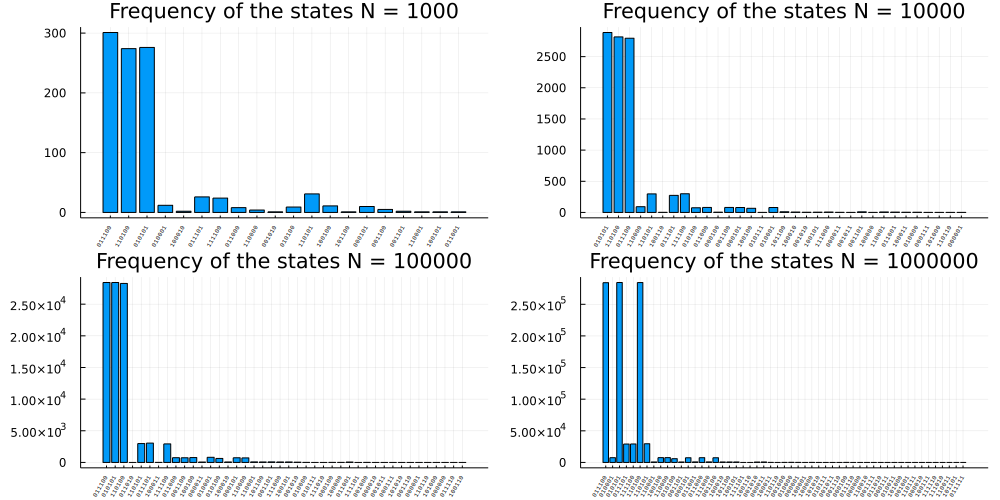

In [48]:
N = [1000, 10000, 100000, 1000000]

dt = 0.001
plots = []

for n in N

    psi = run_annealing(graph, edges, dt)
    samples = measure(psi; nshots=n)
    
    samples_int = [Int(b) for b in samples]
    bins_int = unique(samples_int)
    s = [string(each, base=2, pad=size(graph)[1]) for each in bins_int]

    datamap = countmap(samples)
    bins = unique(samples)
    
    optimal_sol = findmax(datamap)
    println("Optimal Solution for N = ", n)
    println(optimal_sol)
    
    title = @sprintf("Frequency of the states N = %d", n)
    b_plot = bar((x -> datamap[x]).(bins),
        xticks=(1:size(s)[1],s),
        xtickfont = font(3, "Courier"),title=title, legend = false, 
        xrotation=60)
    
    push!(plots, b_plot)
end 

plot(plots...)
plot!(size=(1000,500))

In [43]:
dt = [0.1, 0.01, 0.001, 0.0001, 0.00001]
time = []

for t in dt
    push!(time, @elapsed run_annealing(graph, edges, t))
end

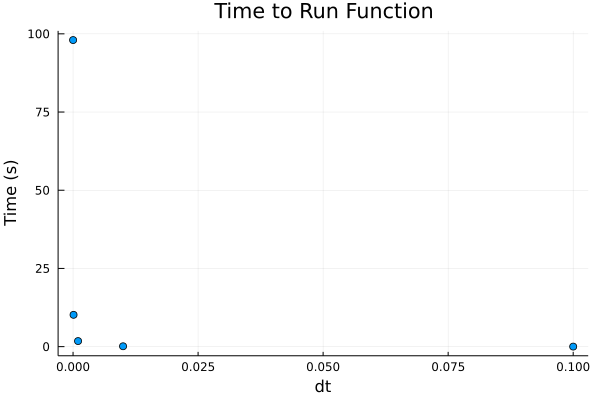

In [44]:
title = @sprintf("Time to Run Function")
scatter(dt,
        time, 
        legend = false,
        title = title,
        xaxis = "dt",
        yaxis = "Time (s)"
)